# Compact Convolutional Transformers (10 points)

In this task you will train Vision Transformer-like network for cifar10 images classification.

This task is based on paper [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/pdf/2104.05704.pdf)

By implementing all the missing code snippets you can get 10 points. Good luck!


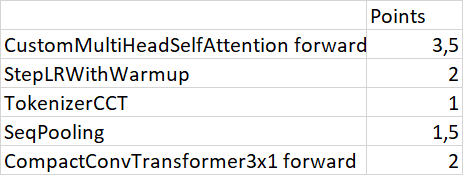

In [2]:
!nvidia-smi

Thu Apr 21 09:40:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# # Determine the locations of auxiliary libraries and datasets.
# # `AUX_DATA_ROOT` is where 'tiny-imagenet-2022.zip' is.

# # Detect if we are in Google Colaboratory
# try:
#     import google.colab
#     IN_COLAB = True
# except ImportError:
#     IN_COLAB = False

# from pathlib import Path
# if IN_COLAB:
#     google.colab.drive.mount("/content/drive")
    
#     # Change this if you created the shortcut in a different location
#     AUX_DATA_ROOT = Path("/content/drive/MyDrive/Deep Learning 2022/HW2/Part2")
    
#     assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
#     import sys
#     sys.path.append(str(AUX_DATA_ROOT))
# else:
#     AUX_DATA_ROOT = Path(".")

## CIFAR dataset

You have already met this dataset in seminars.

* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [4]:
# when running in colab, un-comment this
!wget https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py

--2022-04-21 09:40:50--  https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py
Resolving cloud.imm.uran.ru (cloud.imm.uran.ru)... 195.19.132.75
Connecting to cloud.imm.uran.ru (cloud.imm.uran.ru)|195.19.132.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2182 (2.1K) [text/x-python]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-04-21 09:40:52 (311 MB/s) - ‘cifar.py’ saved [2182/2182]



In [5]:
#!L
import numpy as np
import random
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Load data from cifar_data/cifar-10-batches-py/test_batch
Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


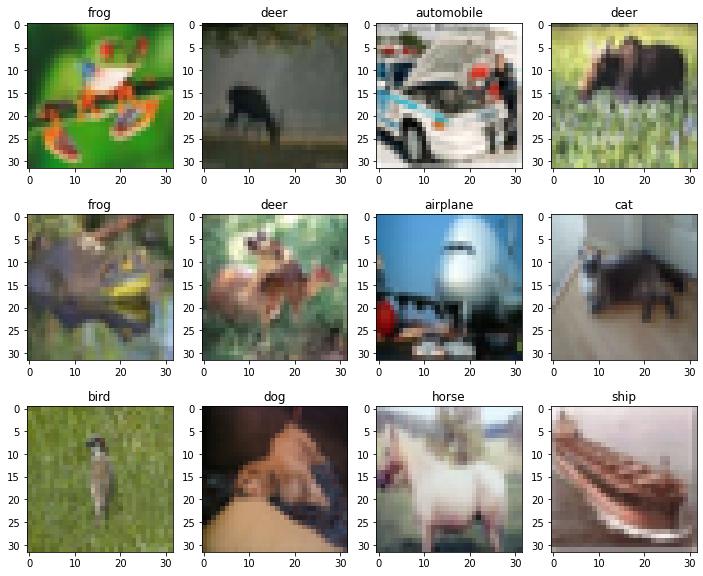

In [6]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.transpose(X_train[i],[1,2,0]))
    plt.title(class_names[y_train[i]])

## Prepare dataset and loss

The following code is based on homework 1-pt2 and should be familiar to you.

In [7]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm

In [8]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [9]:
#!L
def compute_loss(logits, y_batch):
    return F.cross_entropy(logits, y_batch).mean().cpu()

In [10]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2470, 0.2435, 0.2616))

transform_augment = transforms.Compose([
    transforms.RandomResizedCrop((32,32), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation([-5, 5]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [11]:
from torchvision.datasets import CIFAR10

NUM_WORKERS = 2
BATCH_SIZE = 50

train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
val_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)


## Task 1. Multi-head attention

Your turn!

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

Let's implement MultiHeadAttention for beggining. It's already implemented in pytorch, so we will use `nn.MultiHeadAttention` for testing of your implementation.

As a reminder, (one-head) attention implements a simple formula: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$, where $d_k$ is size of K


**Tip: read about how the torch.matmul and torch.t methods work. Think about how they will work for batches and what dimension the tensors will have.**

In [12]:
# Complete CustomMultiHeadSelfAttention in modules.py

Let's check that your implementation works like `torch.nn.MultiheadAttention`

In [13]:
%load_ext autoreload
%autoreload 2

In [15]:
from modules import * #CustomMultiHeadSelfAttention, StepLRWithWarmup,\
                       # TokenizerCCT, SeqPooling, create_mlp, DropPath, TransformerEncoder, CompactConvTransformer3x1

In [16]:
mha = torch.nn.MultiheadAttention(embed_dim=128, num_heads=16, batch_first=True)

In [31]:
custom_mha = CustomMultiHeadSelfAttention(embed_dim=128, num_heads=16)
custom_mha.in_proj.weight = mha.in_proj_weight
custom_mha.in_proj.bias = mha.in_proj_bias
custom_mha.out_proj.weight = mha.out_proj.weight
custom_mha.out_proj.bias = mha.out_proj.bias

In [32]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

for _ in range(100):
    a = torch.rand((1, 10, 128))
    out1 = mha(a, a, a)[0].cpu().detach().numpy()
    out2 = custom_mha(a).cpu().detach().numpy()
    assert np.allclose(out1, out2, atol=1e-6), f"{out1} {out2}"
    
print ("Congratulations! It works!")

Congratulations! It works!


## Task 2: Step-wise learning rate with warm-up

Your task is to implement class that works as `torch.optim.lr_scheduler.StepLR` but supports warm-up.

First of all, examine the docstring and implementation of `StepLR` scheduler:

In [19]:
torch.optim.lr_scheduler.StepLR??

Then implement `get_lr()` method. It should work as following:
1. If `self.last_epoch` is in `[0, self.warmup_epochs)`, then scheduler is in warm-up mode and learning rate should lineary increase during epochs from `self.warmup_lr_init` to `self.base_lrs` (which is the original learning rate of optimizer)
2. If `self.last_epoch` is equal to `self.warmup_epochs`, then just return `self.base_lrs`.
3. If `self.last_epoch - self.warmup_epochs` is not divisible by `self.step_size` then just return the previous learning rate which is available through `[group['lr'] for group in self.optimizer.param_groups]`
4. If `self.last_epoch - self.warmup_epochs` is divisible by `self.step_size` and the current learning rate multiplied by `self.gamma` is not less then self.min_lr, then multiply it and return the new value.
5. Otherwise just return the last learning rate

In [20]:
# Complete class StepLRWithWarmup in modules.py

Let's check what you have written.


All asserts were passed!


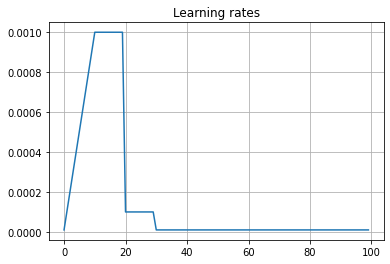

In [33]:
WARMUP_LR_INIT = 1e-5
WARMUP_EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
MIN_LR = 1e-5
OPT_LR = 1e-3

dummy_net = nn.Sequential(nn.Linear(10,10))
dummy_opt = torch.optim.Adam(dummy_net.parameters(), lr=OPT_LR)

scheduler = StepLRWithWarmup(dummy_opt, step_size=STEP_SIZE, gamma=GAMMA, 
                                      warmup_epochs=WARMUP_EPOCHS, warmup_lr_init=WARMUP_LR_INIT,
                                      min_lr=MIN_LR)

# we need to do at least one optimizer step before calling scheduler.step()
# in order to make pytorch happy
dummy_opt.step()  


learning_rates = []
for i in range(100):
    learning_rates.append(scheduler.get_last_lr())
    scheduler.step()
    
plt.plot(learning_rates)
plt.grid()
plt.title('Learning rates')
    
assert np.isclose(learning_rates[0], WARMUP_LR_INIT), \
    f"LR on the first epoch should be equal to {WARMUP_LR_INIT}, actual value {learning_rates[0]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS], OPT_LR), \
    f"LR after warmup shold be equal to {OPT_LR}, actual value {learning_rates[WARMUP_EPOCHS]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE-1], OPT_LR), \
    f"LR after warmup + (STEP_SIZE-1) steps should be equal to {OPT_LR}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE], OPT_LR*GAMMA), \
    f"LR after warmup + (STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1], OPT_LR*GAMMA), \
    f"LR after warmup + (2*STEP_SIZE-1) steps should be equal to {OPT_LR*GAMMA}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+2*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (2*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+2*STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+3*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (3*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+3*STEP_SIZE]}"

for i in range(WARMUP_EPOCHS):
    expected_val = WARMUP_LR_INIT + i*(OPT_LR-WARMUP_LR_INIT) / WARMUP_EPOCHS
    actual_val = learning_rates[i]
    assert np.isclose(actual_val, expected_val), \
        f"LR should linary increase from {WARMUP_LR_INIT} to {OPT_LR} during warmup."\
        f"Expected: {expected_val}, actual: {actual_val}, iteration={i}"
assert all(elem[0] >= MIN_LR for elem in learning_rates)
print("All asserts were passed!")

## Task 3. Compact Convolutional Transformer

During seminar you learned the main components of vision transformer: Tokenizer, Transformer encoder, position embeddings. At this point, it's expected that you have solved the ipython notebook from the seminar. If you didn't, then you know what to do before starting the current task)

Your task is to implement Compact Convolutional Transformer (CCT). It has two main changes comparing to the original ViT that was implemented during seminar. The first one is in tokenizer. Authors of CCT suggested to apply the first convolution with stride=1 allowing transformer to work with input patches that overlaps with each other. Since simple removing of stride increases the spatial resolution of the input tensor, we use MaxPool2d with desired stride in order to reduce the number of tokens.

In [22]:
# Complete class TokenizerCCT in modules.py

The second change is that CCT uses learnable pooling instead of class token for global features extraction. Its formula is similar to attention formula:
$$y = \text{softmax}(WX^T+b) * X$$
where $X$ - layer input - matrix of shape [batch_size, n_tokens, n_embedding], $W$, $b$ - learnable parameters, that transform each token embedding vector to 1 element (in fact it's just a linear layer with output_dim=1).

In [23]:
# Complete class SeqPooling in modules.py

### The following three modules were implemented by you during seminar, so you can just copy-paste their implementations.

MLP for transformer encoder is just a simple two-layer perceptron with GELU as non-linearity. It also uses Dropout after each Linear layer in order to reduce overfitting. Important thing is that size of hidden state on MLP is usually several times bigger than size of MLP input.

In [24]:
# Complete create_mlp function in modules.py

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as you did in the first homework in dropout implementation).

In [25]:
# Complete class DropPath in modules.py

In [26]:
# Complete class TransformerEncoder in modules.py

The final class for the CCT. It looks the same as `VisionTransformer` class in seminar notebook, except the custom tokenizer and pooling. Here we implement a simple version of CCT, whose Tokenizer consist of one convolution of 3x3.

In [27]:
# Complete class CompactConvTransformer3x1 in modules.py

## Final training 

If everything was implemented correctly, the following code will give you a model with > 84.5% accuracy (in fact it should be ~87.5%). If you see a smaller number, check your implementation of modules above.

In [34]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = CompactConvTransformer3x1(input_height=32, input_width=32, n_tokens=16, n_input_channels=3, 
                                  embedding_dim=128, num_layers=4, num_heads=4, num_classes=10, mlp_ratio=2)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = StepLRWithWarmup(opt, 40, gamma=0.3, warmup_epochs=10)

In [35]:
import time
from tqdm.notebook import tqdm_notebook
num_epochs = 120 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    train_loss = []
    val_accuracy = []
    
    for X_batch, y_batch in tqdm_notebook(train_batch_gen): # or train_batch_gen
        opt.zero_grad()
        # train on batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)

        loss = compute_loss(logits, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.numpy())
    print (scheduler.get_last_lr())
    scheduler.step()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in tqdm_notebook(val_batch_gen): # or val_batch_gen
        X_batch = X_batch.to(device)
        y_batch = y_batch.numpy()
        logits = model(X_batch).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss)))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy) * 100))

  0%|          | 0/1000 [00:00<?, ?it/s]

[1e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 120 took 85.145s
  training loss (in-iteration): 	2.061217
  validation accuracy: 			32.56 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.00010899999999999999]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 of 120 took 84.605s
  training loss (in-iteration): 	1.712370
  validation accuracy: 			45.80 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000208]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 of 120 took 84.591s
  training loss (in-iteration): 	1.499369
  validation accuracy: 			50.92 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000307]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 of 120 took 84.813s
  training loss (in-iteration): 	1.346962
  validation accuracy: 			58.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000406]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 of 120 took 84.947s
  training loss (in-iteration): 	1.241722
  validation accuracy: 			62.13 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000505]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 of 120 took 85.064s
  training loss (in-iteration): 	1.162212
  validation accuracy: 			61.72 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0006039999999999999]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 of 120 took 84.585s
  training loss (in-iteration): 	1.105140
  validation accuracy: 			62.22 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000703]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8 of 120 took 84.371s
  training loss (in-iteration): 	1.061705
  validation accuracy: 			67.06 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000802]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9 of 120 took 84.808s
  training loss (in-iteration): 	1.023668
  validation accuracy: 			66.81 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000901]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10 of 120 took 84.313s
  training loss (in-iteration): 	0.998708
  validation accuracy: 			69.63 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11 of 120 took 84.037s
  training loss (in-iteration): 	0.969343
  validation accuracy: 			70.77 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12 of 120 took 84.304s
  training loss (in-iteration): 	0.943039
  validation accuracy: 			69.97 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13 of 120 took 83.689s
  training loss (in-iteration): 	0.907527
  validation accuracy: 			70.61 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14 of 120 took 83.788s
  training loss (in-iteration): 	0.877176
  validation accuracy: 			72.33 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15 of 120 took 83.978s
  training loss (in-iteration): 	0.858942
  validation accuracy: 			74.15 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16 of 120 took 84.551s
  training loss (in-iteration): 	0.824197
  validation accuracy: 			74.20 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17 of 120 took 84.328s
  training loss (in-iteration): 	0.810144
  validation accuracy: 			75.84 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18 of 120 took 83.933s
  training loss (in-iteration): 	0.789821
  validation accuracy: 			75.98 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19 of 120 took 84.967s
  training loss (in-iteration): 	0.779205
  validation accuracy: 			75.99 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20 of 120 took 84.241s
  training loss (in-iteration): 	0.753856
  validation accuracy: 			75.04 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 21 of 120 took 83.996s
  training loss (in-iteration): 	0.743890
  validation accuracy: 			76.97 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 22 of 120 took 83.666s
  training loss (in-iteration): 	0.729592
  validation accuracy: 			77.57 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 23 of 120 took 84.054s
  training loss (in-iteration): 	0.717571
  validation accuracy: 			77.16 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 24 of 120 took 83.898s
  training loss (in-iteration): 	0.701514
  validation accuracy: 			75.65 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 25 of 120 took 84.021s
  training loss (in-iteration): 	0.694706
  validation accuracy: 			78.18 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 26 of 120 took 84.167s
  training loss (in-iteration): 	0.680138
  validation accuracy: 			78.05 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 27 of 120 took 83.951s
  training loss (in-iteration): 	0.669821
  validation accuracy: 			79.77 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 28 of 120 took 84.297s
  training loss (in-iteration): 	0.667361
  validation accuracy: 			78.52 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 29 of 120 took 84.284s
  training loss (in-iteration): 	0.646877
  validation accuracy: 			78.18 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 30 of 120 took 83.944s
  training loss (in-iteration): 	0.644593
  validation accuracy: 			79.12 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 31 of 120 took 84.176s
  training loss (in-iteration): 	0.631323
  validation accuracy: 			78.48 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 32 of 120 took 84.323s
  training loss (in-iteration): 	0.625524
  validation accuracy: 			80.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 33 of 120 took 84.821s
  training loss (in-iteration): 	0.626079
  validation accuracy: 			80.42 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 34 of 120 took 84.042s
  training loss (in-iteration): 	0.617225
  validation accuracy: 			80.98 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 35 of 120 took 83.919s
  training loss (in-iteration): 	0.608131
  validation accuracy: 			80.41 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 36 of 120 took 85.136s
  training loss (in-iteration): 	0.599681
  validation accuracy: 			80.72 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 37 of 120 took 84.990s
  training loss (in-iteration): 	0.593597
  validation accuracy: 			81.56 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 38 of 120 took 84.872s
  training loss (in-iteration): 	0.588037
  validation accuracy: 			79.97 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 39 of 120 took 84.781s
  training loss (in-iteration): 	0.582333
  validation accuracy: 			80.67 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 40 of 120 took 84.334s
  training loss (in-iteration): 	0.576556
  validation accuracy: 			81.82 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 41 of 120 took 85.095s
  training loss (in-iteration): 	0.570887
  validation accuracy: 			80.63 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 42 of 120 took 85.386s
  training loss (in-iteration): 	0.561183
  validation accuracy: 			81.31 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 43 of 120 took 84.469s
  training loss (in-iteration): 	0.561991
  validation accuracy: 			82.28 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 44 of 120 took 85.855s
  training loss (in-iteration): 	0.559355
  validation accuracy: 			81.45 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 45 of 120 took 85.270s
  training loss (in-iteration): 	0.550628
  validation accuracy: 			81.32 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 46 of 120 took 83.843s
  training loss (in-iteration): 	0.549399
  validation accuracy: 			80.99 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 47 of 120 took 85.360s
  training loss (in-iteration): 	0.545469
  validation accuracy: 			82.21 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 48 of 120 took 85.607s
  training loss (in-iteration): 	0.535096
  validation accuracy: 			81.59 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 49 of 120 took 85.301s
  training loss (in-iteration): 	0.535302
  validation accuracy: 			82.28 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 50 of 120 took 84.971s
  training loss (in-iteration): 	0.530280
  validation accuracy: 			82.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 51 of 120 took 84.897s
  training loss (in-iteration): 	0.424383
  validation accuracy: 			85.26 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 52 of 120 took 84.953s
  training loss (in-iteration): 	0.396547
  validation accuracy: 			85.47 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 53 of 120 took 85.548s
  training loss (in-iteration): 	0.385693
  validation accuracy: 			85.64 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 54 of 120 took 84.926s
  training loss (in-iteration): 	0.380456
  validation accuracy: 			85.13 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 55 of 120 took 84.340s
  training loss (in-iteration): 	0.375370
  validation accuracy: 			85.80 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 56 of 120 took 84.087s
  training loss (in-iteration): 	0.371739
  validation accuracy: 			85.50 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 57 of 120 took 84.662s
  training loss (in-iteration): 	0.364432
  validation accuracy: 			85.83 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 58 of 120 took 84.327s
  training loss (in-iteration): 	0.359100
  validation accuracy: 			85.11 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 59 of 120 took 84.168s
  training loss (in-iteration): 	0.356466
  validation accuracy: 			85.73 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 60 of 120 took 84.423s
  training loss (in-iteration): 	0.353313
  validation accuracy: 			85.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 61 of 120 took 84.520s
  training loss (in-iteration): 	0.346838
  validation accuracy: 			85.71 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 62 of 120 took 84.961s
  training loss (in-iteration): 	0.347634
  validation accuracy: 			85.65 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 63 of 120 took 85.434s
  training loss (in-iteration): 	0.342251
  validation accuracy: 			86.31 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 64 of 120 took 85.303s
  training loss (in-iteration): 	0.338061
  validation accuracy: 			85.27 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 65 of 120 took 85.422s
  training loss (in-iteration): 	0.337668
  validation accuracy: 			85.50 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 66 of 120 took 85.496s
  training loss (in-iteration): 	0.330395
  validation accuracy: 			85.43 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 67 of 120 took 85.654s
  training loss (in-iteration): 	0.330818
  validation accuracy: 			85.74 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 68 of 120 took 85.491s
  training loss (in-iteration): 	0.324894
  validation accuracy: 			84.59 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 69 of 120 took 85.655s
  training loss (in-iteration): 	0.325117
  validation accuracy: 			85.34 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 70 of 120 took 84.971s
  training loss (in-iteration): 	0.320468
  validation accuracy: 			85.36 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 71 of 120 took 84.579s
  training loss (in-iteration): 	0.320541
  validation accuracy: 			85.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 72 of 120 took 84.800s
  training loss (in-iteration): 	0.318897
  validation accuracy: 			85.79 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 73 of 120 took 84.608s
  training loss (in-iteration): 	0.317559
  validation accuracy: 			85.52 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 74 of 120 took 84.833s
  training loss (in-iteration): 	0.315989
  validation accuracy: 			85.94 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 75 of 120 took 85.062s
  training loss (in-iteration): 	0.311326
  validation accuracy: 			85.89 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 76 of 120 took 85.017s
  training loss (in-iteration): 	0.313604
  validation accuracy: 			85.95 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 77 of 120 took 84.462s
  training loss (in-iteration): 	0.307203
  validation accuracy: 			86.41 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 78 of 120 took 84.922s
  training loss (in-iteration): 	0.306097
  validation accuracy: 			86.96 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 79 of 120 took 85.016s
  training loss (in-iteration): 	0.306731
  validation accuracy: 			85.83 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 80 of 120 took 85.620s
  training loss (in-iteration): 	0.302015
  validation accuracy: 			86.23 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 81 of 120 took 85.223s
  training loss (in-iteration): 	0.296570
  validation accuracy: 			86.10 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 82 of 120 took 85.083s
  training loss (in-iteration): 	0.297913
  validation accuracy: 			86.36 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 83 of 120 took 85.088s
  training loss (in-iteration): 	0.292788
  validation accuracy: 			86.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 84 of 120 took 85.140s
  training loss (in-iteration): 	0.293508
  validation accuracy: 			86.56 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 85 of 120 took 85.355s
  training loss (in-iteration): 	0.290740
  validation accuracy: 			86.54 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 86 of 120 took 85.572s
  training loss (in-iteration): 	0.290792
  validation accuracy: 			86.54 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 87 of 120 took 85.166s
  training loss (in-iteration): 	0.290083
  validation accuracy: 			86.42 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 88 of 120 took 85.406s
  training loss (in-iteration): 	0.287642
  validation accuracy: 			86.61 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 89 of 120 took 85.080s
  training loss (in-iteration): 	0.287913
  validation accuracy: 			86.50 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 90 of 120 took 85.947s
  training loss (in-iteration): 	0.285762
  validation accuracy: 			86.12 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 91 of 120 took 86.091s
  training loss (in-iteration): 	0.236531
  validation accuracy: 			87.00 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 92 of 120 took 86.050s
  training loss (in-iteration): 	0.221824
  validation accuracy: 			86.84 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 93 of 120 took 85.489s
  training loss (in-iteration): 	0.223175
  validation accuracy: 			87.05 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 94 of 120 took 85.890s
  training loss (in-iteration): 	0.220408
  validation accuracy: 			86.93 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 95 of 120 took 85.868s
  training loss (in-iteration): 	0.214865
  validation accuracy: 			86.98 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 96 of 120 took 85.904s
  training loss (in-iteration): 	0.214265
  validation accuracy: 			86.95 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 97 of 120 took 86.129s
  training loss (in-iteration): 	0.210290
  validation accuracy: 			87.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 98 of 120 took 85.983s
  training loss (in-iteration): 	0.210627
  validation accuracy: 			87.08 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 99 of 120 took 85.727s
  training loss (in-iteration): 	0.207627
  validation accuracy: 			87.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 100 of 120 took 85.812s
  training loss (in-iteration): 	0.209869
  validation accuracy: 			87.07 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 101 of 120 took 86.422s
  training loss (in-iteration): 	0.203833
  validation accuracy: 			87.05 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 102 of 120 took 87.206s
  training loss (in-iteration): 	0.202621
  validation accuracy: 			87.26 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 103 of 120 took 87.064s
  training loss (in-iteration): 	0.200576
  validation accuracy: 			87.22 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 104 of 120 took 85.195s
  training loss (in-iteration): 	0.204190
  validation accuracy: 			86.99 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 105 of 120 took 87.037s
  training loss (in-iteration): 	0.201693
  validation accuracy: 			87.10 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 106 of 120 took 86.878s
  training loss (in-iteration): 	0.198463
  validation accuracy: 			86.73 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 107 of 120 took 87.187s
  training loss (in-iteration): 	0.201391
  validation accuracy: 			87.35 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 108 of 120 took 85.810s
  training loss (in-iteration): 	0.196199
  validation accuracy: 			87.16 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 109 of 120 took 85.637s
  training loss (in-iteration): 	0.198597
  validation accuracy: 			86.60 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 110 of 120 took 85.330s
  training loss (in-iteration): 	0.193314
  validation accuracy: 			86.81 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 111 of 120 took 87.008s
  training loss (in-iteration): 	0.192991
  validation accuracy: 			86.74 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 112 of 120 took 87.533s
  training loss (in-iteration): 	0.195373
  validation accuracy: 			86.89 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 113 of 120 took 87.610s
  training loss (in-iteration): 	0.189768
  validation accuracy: 			86.68 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 114 of 120 took 86.570s
  training loss (in-iteration): 	0.191979
  validation accuracy: 			87.12 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 115 of 120 took 86.741s
  training loss (in-iteration): 	0.188953
  validation accuracy: 			86.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 116 of 120 took 87.601s
  training loss (in-iteration): 	0.188291
  validation accuracy: 			87.19 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 117 of 120 took 88.205s
  training loss (in-iteration): 	0.188125
  validation accuracy: 			86.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 118 of 120 took 87.829s
  training loss (in-iteration): 	0.187944
  validation accuracy: 			86.81 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 119 of 120 took 87.605s
  training loss (in-iteration): 	0.188791
  validation accuracy: 			86.91 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 120 of 120 took 88.275s
  training loss (in-iteration): 	0.184941
  validation accuracy: 			87.26 %
